# AHRI Mortality
MIT student visit 18 January 2024

## Get the Data
Download the data from the SAPRIN Data Repository: https://saprindata.samrc.ac.za/index.php/catalog/85
It is public access, but you need to register to download the data

1. ### Set up the Julia packages we will be using:
    - CSV - To read the downloaded data
    - DataFrames - to process the data once read from the CSV file
    - CarioMakie and AlgebraOfGraphics to plot our results 

In [1]:
using CSV
using DataFrames
using CairoMakie
using AlgebraOfGraphics

2. ### Read the downloaded CSV file

In [2]:
df = CSV.read(/Users/kobush/Library/CloudStorage/OneDrive-AHRI/ACDIS/Projects/SAPRIN/Data Extraction/SAPRIN_Data/SAPRIN_YrAge_Episodes.csv, DataFrame)

Row,NodeId,IndividualId,Sex,DoB,DoD,MotherId,FatherId,CalendarYear,Age,StartDate,EndDate,Episodes,Episode,LocationId,HouseholdId,Resident,Enumeration,Born,InMigration,LocationEntry,ExtResStart,Participation,YrStart,AgeStart,Died,OutMigration,LocationExit,ExtResEnd,LostToFollowUp,Refusal,YrEnd,AgeEnd,MembershipStart,MembershipEnd,Memberships,Gap,Days,Current
,Int64,Int64,Int64,String15,String15?,Int64?,Int64?,Int64,Int64,String15,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,1,1,18jun1994,missing,287883,285997,1994,0,18jun1994,31dec1994,23,1,19540,13936,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,197,0
2,1,1,1,18jun1994,missing,287883,285997,1995,0,01jan1995,17jun1995,23,2,19540,13936,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,168,0
3,1,1,1,18jun1994,missing,287883,285997,1995,1,18jun1995,31dec1995,23,3,19540,13936,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,197,0
4,1,1,1,18jun1994,missing,287883,285997,1996,1,01jan1996,17jun1996,23,4,19540,13936,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,169,0
5,1,1,1,18jun1994,missing,287883,285997,1996,2,18jun1996,31dec1996,23,5,19540,13936,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,197,0
6,1,1,1,18jun1994,missing,287883,285997,1997,2,01jan1997,17jun1997,23,6,19540,13936,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,168,0
7,1,1,1,18jun1994,missing,287883,285997,1997,3,18jun1997,31dec1997,23,7,19540,13936,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,197,0
8,1,1,1,18jun1994,missing,287883,285997,1998,3,01jan1998,17jun1998,23,8,19540,13936,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,168,0
9,1,1,1,18jun1994,missing,287883,285997,1998,4,18jun1998,31dec1998,23,9,19540,13936,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,197,0


In [6]:
# List the column names
print(names(df))

["NodeId", "IndividualId", "Sex", "DoB", "DoD", "MotherId", "FatherId", "CalendarYear", "Age", "StartDate", "EndDate", "Episodes", "Episode", "LocationId", "HouseholdId", "Resident", "Enumeration", "Born", "InMigration", "LocationEntry", "ExtResStart", "Participation", "YrStart", "AgeStart", "Died", "OutMigration", "LocationExit", "ExtResEnd", "LostToFollowUp", "Refusal", "YrEnd", "AgeEnd", "MembershipStart", "MembershipEnd", "Memberships", "Gap", "Days", "Current"]

### Columns
NodeId  
IndividualId  
**Sex**  
DoB  
DoD  
...  
**CalendarYear**  
**Age**  
StartDate  
EndDate  
Episodes  
Episode  
LocationId  
HouseholdId  
**Resident**  
Enumeration, Born, InMigration, LocationEntry, ExtResStart, Participation, ...,   
Died, OutMigration, LocationExit, ExtResEnd, LostToFollowUp, Refusal, ...,   
**Days**  
**Current**  

In [7]:
# List the first 5 rows
first(df, 5)

Row,NodeId,IndividualId,Sex,DoB,DoD,MotherId,FatherId,CalendarYear,Age,StartDate,EndDate,Episodes,Episode,LocationId,HouseholdId,Resident,Enumeration,Born,InMigration,LocationEntry,ExtResStart,Participation,YrStart,AgeStart,Died,OutMigration,LocationExit,ExtResEnd,LostToFollowUp,Refusal,YrEnd,AgeEnd,MembershipStart,MembershipEnd,Memberships,Gap,Days,Current
,Int64,Int64,Int64,String15,String15?,Int64?,Int64?,Int64,Int64,String15,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,1,1,18jun1994,missing,287883,285997,1994,0,18jun1994,31dec1994,23,1,19540,13936,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,197,0
2,1,1,1,18jun1994,missing,287883,285997,1995,0,01jan1995,17jun1995,23,2,19540,13936,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,168,0
3,1,1,1,18jun1994,missing,287883,285997,1995,1,18jun1995,31dec1995,23,3,19540,13936,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,197,0
4,1,1,1,18jun1994,missing,287883,285997,1996,1,01jan1996,17jun1996,23,4,19540,13936,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,169,0
5,1,1,1,18jun1994,missing,287883,285997,1996,2,18jun1996,31dec1996,23,5,19540,13936,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,197,0


In [8]:
# List the last 5 rows
last(df, 5)

Row,NodeId,IndividualId,Sex,DoB,DoD,MotherId,FatherId,CalendarYear,Age,StartDate,EndDate,Episodes,Episode,LocationId,HouseholdId,Resident,Enumeration,Born,InMigration,LocationEntry,ExtResStart,Participation,YrStart,AgeStart,Died,OutMigration,LocationExit,ExtResEnd,LostToFollowUp,Refusal,YrEnd,AgeEnd,MembershipStart,MembershipEnd,Memberships,Gap,Days,Current
,Int64,Int64,Int64,String15,String15?,Int64?,Int64?,Int64,Int64,String15,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,3,256425,1,21dec1986,missing,missing,missing,2021,34,01jan2021,20dec2021,9,5,15678,164,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,354,0
2,3,256425,1,21dec1986,missing,missing,missing,2021,35,21dec2021,31dec2021,9,6,15678,164,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,11,0
3,3,256425,1,21dec1986,missing,missing,missing,2022,35,01jan2022,20dec2022,9,7,15678,164,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,354,0
4,3,256425,1,21dec1986,missing,missing,missing,2022,36,21dec2022,23dec2022,9,8,15678,164,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,3,0
5,3,256425,1,21dec1986,missing,missing,missing,2022,36,24dec2022,31dec2022,9,9,15678,164,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,8,1


In [10]:
# Number of records for each NodeId
rd = combine(groupby(df, :NodeId), nrow => :freq)

Row,NodeId,freq
,Int64,Int64
1,1,5679572
2,2,1892196
3,3,5347948


### SAPRIN Nodes
1 = Agincourt<br>
2 = DIMAMO<br>
3 = AHRI<br>

#### We will continue working only with AHRI data for residents up to 2022

In [27]:
ahri = subset(df, :NodeId => ByRow(x -> x == 3), :CalendarYear => ByRow(x -> x <= 2022), :Resident=> ByRow(x -> x == 1))

Row,NodeId,IndividualId,Sex,DoB,DoD,MotherId,FatherId,CalendarYear,Age,StartDate,EndDate,Episodes,Episode,LocationId,HouseholdId,Resident,Enumeration,Born,InMigration,LocationEntry,ExtResStart,Participation,YrStart,AgeStart,Died,OutMigration,LocationExit,ExtResEnd,LostToFollowUp,Refusal,YrEnd,AgeEnd,MembershipStart,MembershipEnd,Memberships,Gap,Days,Current
,Int64,Int64,Int64,String15,String15?,Int64?,Int64?,Int64,Int64,String15,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,3,1,2,22nov2009,missing,5774,missing,2010,0,04mar2010,21nov2010,26,1,14110,6624,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,263,0
2,3,1,2,22nov2009,missing,5774,missing,2010,1,22nov2010,31dec2010,26,2,14110,6624,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,40,0
3,3,1,2,22nov2009,missing,5774,missing,2011,1,01jan2011,21nov2011,26,3,14110,6624,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,325,0
4,3,1,2,22nov2009,missing,5774,missing,2011,2,22nov2011,31dec2011,26,4,14110,6624,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,40,0
5,3,1,2,22nov2009,missing,5774,missing,2012,2,01jan2012,21nov2012,26,5,14110,6624,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,326,0
6,3,1,2,22nov2009,missing,5774,missing,2012,3,22nov2012,31dec2012,26,6,14110,6624,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,40,0
7,3,1,2,22nov2009,missing,5774,missing,2013,3,01jan2013,21nov2013,26,7,14110,6624,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,325,0
8,3,1,2,22nov2009,missing,5774,missing,2013,4,22nov2013,31dec2013,26,8,14110,6624,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,40,0
9,3,1,2,22nov2009,missing,5774,missing,2014,4,01jan2014,21nov2014,26,9,14110,6624,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,325,0


In [28]:
# Number of births per year
births = combine(groupby(ahri, :CalendarYear), :Born => sum => :Births)

Row,CalendarYear,Births
,Int64,Int64
1,2000,1683
2,2001,1733
3,2002,1742
4,2003,1663
5,2004,1786
6,2005,1817
7,2006,1806
8,2007,1821
9,2008,1836


In [29]:
# Number of deaths per year
deaths = combine(groupby(ahri, :CalendarYear), :Died => sum => :Deaths)

Row,CalendarYear,Deaths
,Int64,Int64
1,2000,890
2,2001,1080
3,2002,1100
4,2003,1128
5,2004,985
6,2005,980
7,2006,890
8,2007,921
9,2008,814


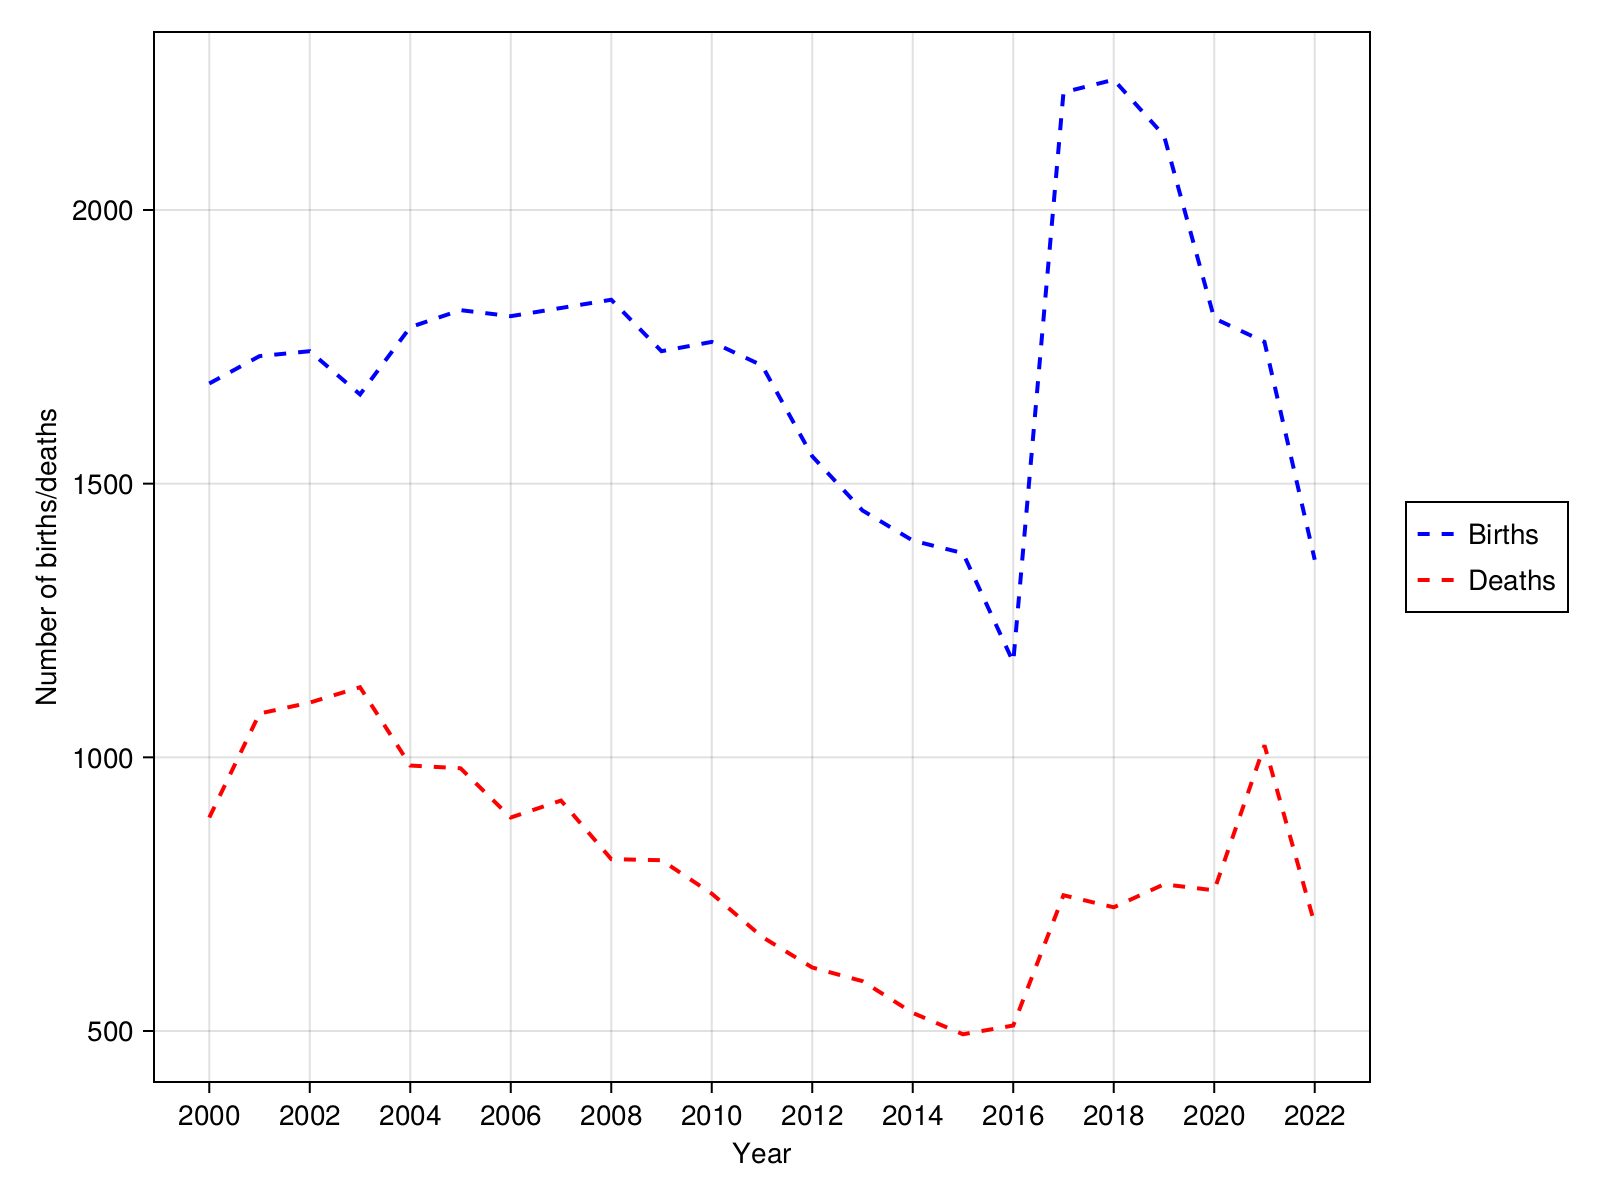

In [30]:
# Let's plot the number of births and deaths per year
fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Year", ylabel = "Number of births/deaths", xticks = 2000:2:2022)
lines!(ax, births.CalendarYear, births.Births, color = :blue, linewidth = 2, linestyle = :dash, label = "Births")
lines!(ax, deaths.CalendarYear, deaths.Deaths, color = :red, linewidth = 2, linestyle = :dash, label = "Deaths")
Legend(fig[1, 2], ax, label = ["Births" "Deaths"], loc = :best)
fig

These graphs look a bit strange - why the sudden increase in births in 2017?

Could it be that the denominator have changes over the years?

In [31]:
# Let's check when new persons were enumerated
enums = combine(groupby(ahri, :CalendarYear), :Enumeration => sum => :Freq)

Row,CalendarYear,Freq
,Int64,Int64
1,2000,62656
2,2001,35
3,2002,27
4,2003,15
5,2004,10
6,2005,5
7,2006,6
8,2007,14
9,2008,8


So we rather need to look at **rates**.<br>
$$Rate = \frac{numerator}{denominator}$$
*numerator* = Number of births/deaths<br>
*denominator* = Person years of exposure



In [36]:
# Calculate birth rate per year
birthrate = combine(groupby(ahri, :CalendarYear), :Born => sum => :Births, :Days => sum => :Days)
transform!(birthrate, :Days => ByRow(x -> x / 365) => :PersonYears)
transform!(birthrate, [:Births,:PersonYears] => ByRow((x,y) -> (x / y)*1000) => :BirthRate)

Row,CalendarYear,Births,Days,PersonYears,BirthRate
,Int64,Int64,Int64,Float64,Float64
1,2000,1683,23541522,64497.3,26.0941
2,2001,1733,24675921,67605.3,25.6341
3,2002,1742,24722985,67734.2,25.7182
4,2003,1663,24177695,66240.3,25.1056
5,2004,1786,23881259,65428.1,27.2971
6,2005,1817,23788798,65174.8,27.8789
7,2006,1806,23998920,65750.5,27.4675
8,2007,1821,24235703,66399.2,27.425
9,2008,1836,24469916,67040.9,27.3863


In [37]:
# Calculate death rate per year
deathrate = combine(groupby(ahri, :CalendarYear), :Died => sum => :Deaths, :Days => sum => :Days)
transform!(deathrate, :Days => ByRow(x -> x / 365) => :PersonYears)
transform!(deathrate, [:Deaths,:PersonYears] => ByRow((x,y) -> (x / y)*1000) => :DeathRate)

Row,CalendarYear,Deaths,Days,PersonYears,DeathRate
,Int64,Int64,Int64,Float64,Float64
1,2000,890,23541522,64497.3,13.799
2,2001,1080,24675921,67605.3,15.9751
3,2002,1100,24722985,67734.2,16.2399
4,2003,1128,24177695,66240.3,17.0289
5,2004,985,23881259,65428.1,15.0547
6,2005,980,23788798,65174.8,15.0365
7,2006,890,23998920,65750.5,13.536
8,2007,921,24235703,66399.2,13.8707
9,2008,814,24469916,67040.9,12.1418


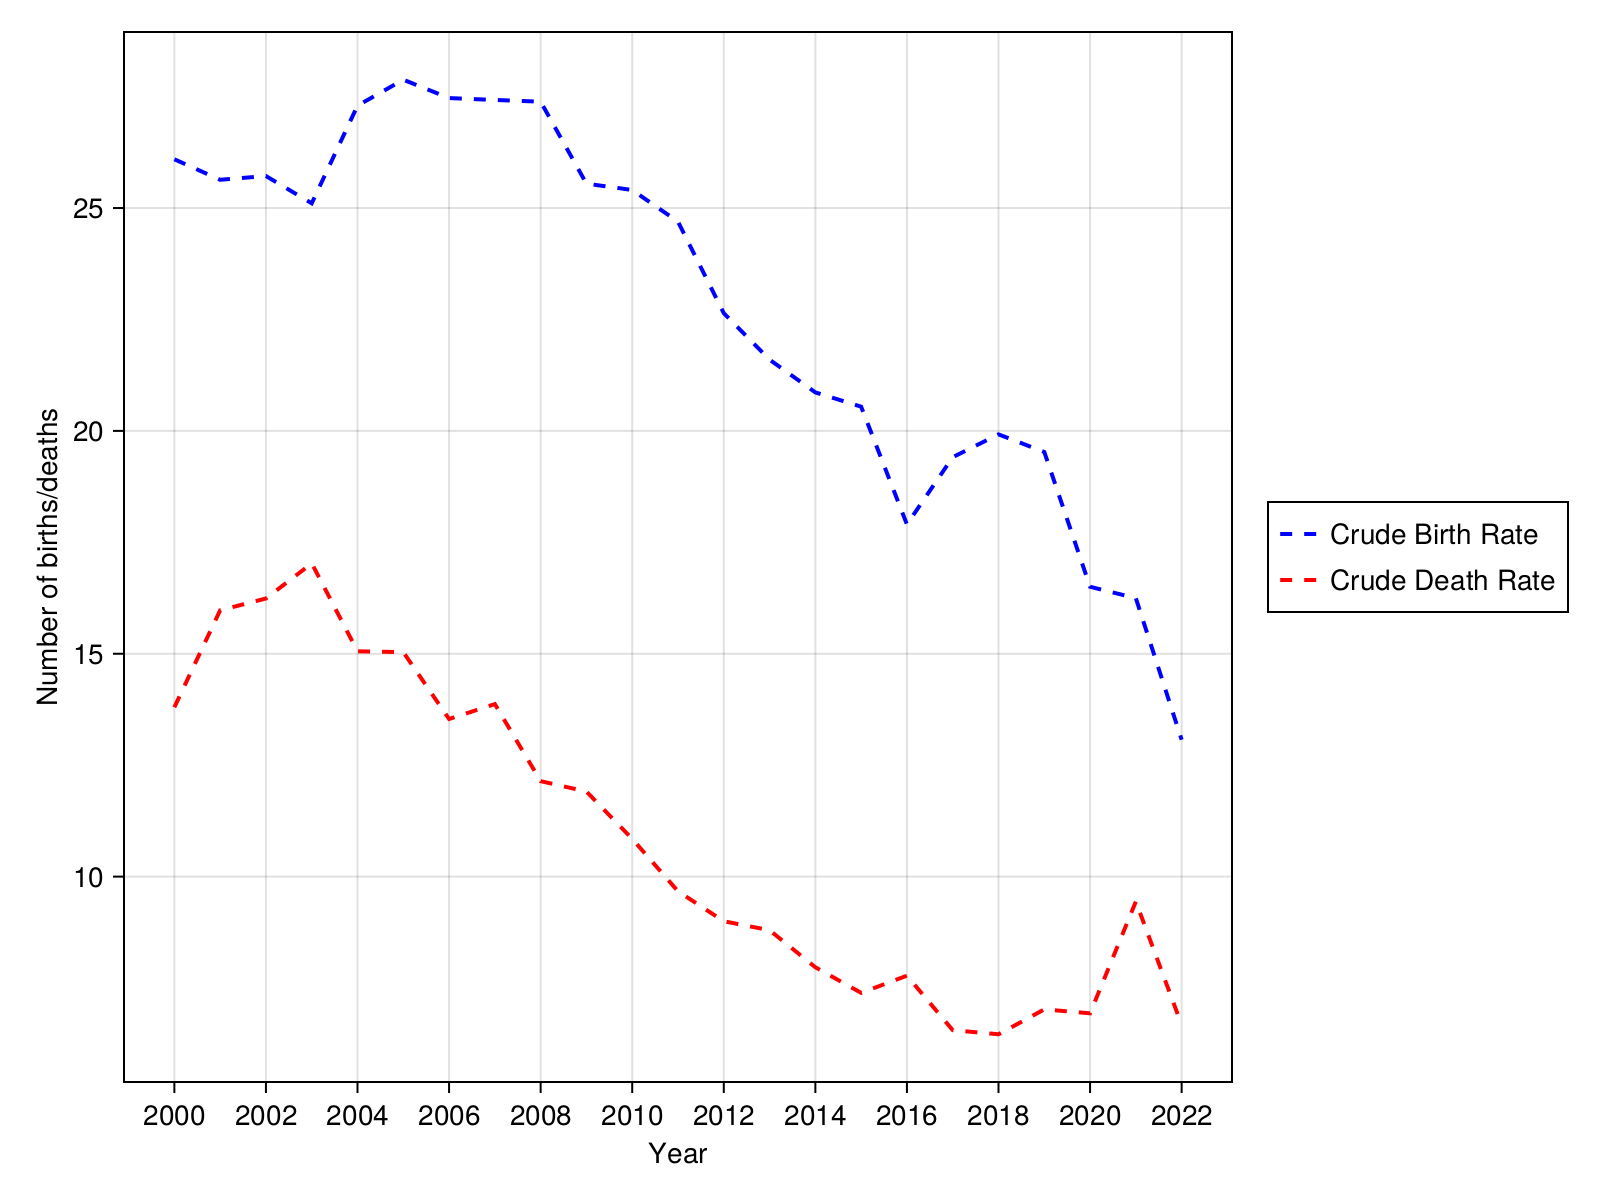

In [38]:
# Let's plot the number of births and deaths per year
fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Year", ylabel = "Number of births/deaths", xticks = 2000:2:2022)
lines!(ax, birthrate.CalendarYear, birthrate.BirthRate, color = :blue, linewidth = 2, linestyle = :dash, label = "Crude Birth Rate")
lines!(ax, deathrate.CalendarYear, deathrate.DeathRate, color = :red, linewidth = 2, linestyle = :dash, label = "Crude Death Rate")
Legend(fig[1, 2], ax, label = ["Crude Birth Rate" "Crude Death Rate"], loc = :best)
fig